# Object Detection on Indian Railway Features

#### Import Libraries

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

#### Define Transformation

In [2]:
class CocoTransform:
    def __call__(self, image, target):
        image = F.to_tensor(image) # Convert PIL image to tensor
        return image, target

#### Load Dataset

In [3]:
# Dataset class
def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(
        root = img_dir,
        annFile = ann_file,
        transforms = CocoTransform()
    )

# Load Datasets
train_dataset = get_coco_dataset(
    img_dir = "Dataset/train",
    ann_file = "Dataset/train/annotation.json"
)

val_dataset = get_coco_dataset(
    img_dir = "Dataset/valid",
    ann_file = "Dataset/valid/valid_annotation.json"
)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn = lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size = 2, shuffle=False, collate_fn = lambda x: tuple(zip(*x))) 

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


#### Load Faster R-CNN with ResNet 59 backbone

In [4]:
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

#### Intialize the model

In [5]:
num_classes = 7 # OHE Pole, Signal Pole, Silver Box, Sign Board, Station Name Board, Tunnel)
model = get_model(num_classes)

D:\Pytorch\.myvenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Pytorch\.myvenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Coonect GPU

In [6]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')
model.to(device)

#### Define optimizer and learning rate scheduler

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [7]:
import torch
print(torch.cuda.is_available()) 
print(torch.backends.cudnn.enabled) 


True
True


#### Model Train by Epoch

In [8]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    for images, targets in data_loader:
        # Move images to device
        images = [img.to(device) for img in images]

        # Validate and process targets
        processed_targets = []
        valid_images = []
        for i, target in enumerate(targets):
            boxes = []
            labels = []
            for obj in target:
                #Extract bbox
                bbox = obj["bbox"] # Format:[x,y, w,h]
                x, y, w, h = bbox

                # Ensure the width and hieght are postive
                if w > 0 and h > 0:
                    boxes.append([x, y, x+w, y+h]) # Convert to [x_min, y_min, x_max, y_max]
                    labels.append(obj["category_id"])

            # Only process if there are valid boxes
            if boxes:
                processed_target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                    "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                }
                processed_targets.append(processed_target)
                valid_images.append(images[i]) 

        # Skip iteration if no vaild targets
        if not processed_targets:
            continue

        # Ensure images and targets are aligned
        images = valid_images

        # Forward Pass
        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 

    print(f"Epoch [{epoch}] Loss: {losses.item():.4f}")
                

#### Training Loop:

In [9]:
num_epochs = 50
for epoch in range (num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()

    # Save the model's state dictionary after every epoch
    model_path = f"fasterrcnn_resnet50_epoch_{epoch +1}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Madel Saved: {model_path}")

Epoch [0] Loss: 0.5273
Madel Saved: fasterrcnn_resnet50_epoch_1.pth
Epoch [1] Loss: 0.2565
Madel Saved: fasterrcnn_resnet50_epoch_2.pth
Epoch [2] Loss: 0.3365
Madel Saved: fasterrcnn_resnet50_epoch_3.pth
Epoch [3] Loss: 0.1386
Madel Saved: fasterrcnn_resnet50_epoch_4.pth
Epoch [4] Loss: 0.1576
Madel Saved: fasterrcnn_resnet50_epoch_5.pth
Epoch [5] Loss: 0.1085
Madel Saved: fasterrcnn_resnet50_epoch_6.pth
Epoch [6] Loss: 0.2330
Madel Saved: fasterrcnn_resnet50_epoch_7.pth
Epoch [7] Loss: 0.0952
Madel Saved: fasterrcnn_resnet50_epoch_8.pth
Epoch [8] Loss: 0.0742
Madel Saved: fasterrcnn_resnet50_epoch_9.pth
Epoch [9] Loss: 0.1326
Madel Saved: fasterrcnn_resnet50_epoch_10.pth
Epoch [10] Loss: 0.1214
Madel Saved: fasterrcnn_resnet50_epoch_11.pth
Epoch [11] Loss: 0.1822
Madel Saved: fasterrcnn_resnet50_epoch_12.pth
Epoch [12] Loss: 0.1011
Madel Saved: fasterrcnn_resnet50_epoch_13.pth
Epoch [13] Loss: 0.0915
Madel Saved: fasterrcnn_resnet50_epoch_14.pth
Epoch [14] Loss: 0.0429
Madel Saved: fa

#### Model Evaluation

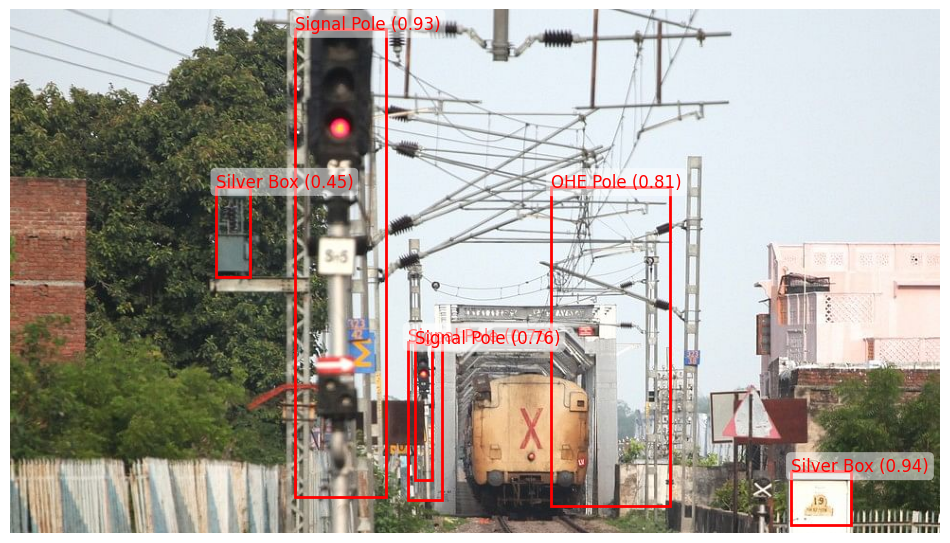

In [33]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


# Initialize the model
num_classes = 7  # Background, OHE Pole, Signal Pole, Silver Box, Sign Board, Station Name Board, Tunnel

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the trained model
model = get_model(num_classes)
model.load_state_dict(torch.load("trained models/fasterrcnn_resnet50_epoch_29.pth")) # Used trained model from above models
model.to(device)
model.eval()  


def prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")  
    image_tensor = F.to_tensor(image).unsqueeze(0)  
    return image_tensor.to(device)



# Load the unseen image
image_path = "Dataset/test/Indian_Railway_15.jpg"
image_tensor = prepare_image(image_path)

with torch.no_grad():  
    prediction = model(image_tensor)

COCO_CLASSES = {0: "Background", 1: "OHE Pole", 2: "Signal Pole", 3: "Silver Box",4: "Sign Board",5: "Station Name Board", 6: "Tunnel"}

def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "Unknown")
    
# Draw bounding boxes with the correct class names and increase image size
def draw_boxes(image, prediction, fig_size=(10, 10)):
    boxes = prediction[0]['boxes'].cpu().numpy()  
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy() 

    threshold = 0.3  # Set a confidence threshold

    plt.figure(figsize=fig_size) 
    plt.imshow(image) 

    ax = plt.gca()  

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            class_name = get_class_name(label) 
            
            # Draw bounding box
            ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                       linewidth=2, edgecolor='r', facecolor='none'))
            
            # Add label text
            ax.text(x_min, y_min, f"{class_name} ({score:.2f})", color='r', fontsize=12,
                    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.3'))

    plt.axis('off') 
    plt.show()  

# Display the image with bounding boxes
draw_boxes(Image.open(image_path), prediction, fig_size=(12, 10))

#### Prediction and Bounding Boxes Co-ordinates

In [34]:
with torch.no_grad():
    prediction = model(image_tensor)

# Print predictions to check if the model is detecting anything
print("Predicted Labels:", prediction[0]['labels'].cpu().numpy())
print("Scores:", prediction[0]['scores'].cpu().numpy())
print("Boxes:", prediction[0]['boxes'].cpu().numpy())

Predicted Labels: [3 2 1 2 2 3 1 1 2 3 4 4 6 4 3 4 1 2 1 1 2 2 1 6 6 1 1 1 1 1 1]
Scores: [0.9410804  0.93048173 0.8131312  0.76118135 0.7560263  0.4509083
 0.29760128 0.21572214 0.20847045 0.18834373 0.1828093  0.17812064
 0.14174025 0.12504645 0.12429831 0.12137898 0.09773823 0.09670345
 0.09337107 0.08505568 0.08222976 0.0791806  0.07787546 0.0711884
 0.06985812 0.06627131 0.06556063 0.06529933 0.05533606 0.05496208
 0.05243352]
Boxes: [[824.267    487.18378  887.51575  544.0837  ]
 [300.29376   20.100435 396.83206  514.88074 ]
 [570.97406  187.31003  696.383    523.63196 ]
 [419.42313  350.44806  456.1114   517.7593  ]
 [426.9416   351.74866  445.16922  497.0557  ]
 [216.50566  186.99016  252.80966  282.10364 ]
 [342.95224   13.901567 747.13293  185.3712  ]
 [266.22437   30.099619 688.3945   508.50516 ]
 [557.28845  230.09451  737.6795   501.08453 ]
 [737.8409   403.46927  786.1467   456.05072 ]
 [219.41537  188.37883  254.35153  288.07535 ]
 [824.34216  487.1718   893.2218   548.1